In [68]:
#@title Import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.tsa.stattools import adfuller

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#@title AR(1)->AR(3) Function
def generate_ar1(N, phi, sigma, initial_value):
    ar1_values = np.zeros(N+1)
    ar1_values[0] = initial_value
    for i in range(1, N+1):
        ar1_values[i] = phi * ar1_values[i - 1] + np.random.normal(0, sigma)
    return ar1_values

def ar3_analysis_from_ar1(N, phi, sigma=1, initial_value=0):
    data = np.zeros((N+1, 1000))  
    for i in range(1000):
        np.random.seed(i)
        data[:, i] = generate_ar1(N, phi, sigma, initial_value)

    ar1_dataframe = pd.DataFrame(data)
    actual_value = pd.DataFrame(ar1_dataframe.tail(1))
    actual_value = actual_value.transpose()
    actual_value = actual_value.rename(columns={actual_value.columns[0]: 'Actual_value'})

    ar1_dataframe.drop(ar1_dataframe.tail(1).index, inplace=True)


    param_estimates = []
    std_errors = []
    ljungbox_stats = {lag: [] for lag in range(1, 4)}
    ljungbox_pvalues = {lag: [] for lag in range(1, 4)}
    basic_stats = {'mean': [], 'min': [], 'max': [], 'median': [], 'skewness': [], 'kurtosis': []}
    bias_test = {'Intercept_Bias': [], 'Lag1_Bias': [], 'Lag2_Bias': [], 'Lag3_Bias': []}
    normality_test_pvalues = []  
    significance_tests = {'Lag2_pvalue': [], 'Lag3_pvalue': []}  
    next_value_estimates = []  


    true_params = {'Intercept': 0, 'Lag1': phi, 'Lag2': 0, 'Lag3': 0}

    # Estymacja modelu AR(3) dla każdej kolumny
    for i in range(1000):
        model = sm.tsa.AutoReg(data[:, i], lags=3)
        results = model.fit()

        # Zapisujemy wartości parametrów i ich odchylenia standardowe
        param_estimates.append(results.params)
        std_errors.append(results.bse)

        # Obliczanie obciążenia estymatorów
        params_dict = dict(zip(['Intercept', 'Lag1', 'Lag2', 'Lag3'], results.params))
        for param_name, true_value in true_params.items():
            bias_test[f'{param_name}_Bias'].append(params_dict[param_name] - true_value)

        # Reszty modelu
        residuals = results.resid

        # Test Ljung-Box dla reszt (dla opóźnień 1, 2, 3)
        lb_test = acorr_ljungbox(residuals, lags=[1, 2, 3], return_df=True)
        for idx, lag in enumerate([1, 2, 3]):  
            ljungbox_stats[lag].append(lb_test.iloc[idx]['lb_stat'])
            ljungbox_pvalues[lag].append(lb_test.iloc[idx]['lb_pvalue'])

        # Test normalności reszt (Shapiro-Wilk)
        stat, p_value = shapiro(residuals)
        normality_test_pvalues.append(p_value)

        # Obliczenie podstawowych statystyk
        basic_stats['mean'].append(np.mean(data[:, i]))
        basic_stats['min'].append(np.min(data[:, i]))
        basic_stats['max'].append(np.max(data[:, i]))
        basic_stats['median'].append(np.median(data[:, i]))
        basic_stats['skewness'].append(skew(data[:, i]))
        basic_stats['kurtosis'].append(kurtosis(data[:, i]))

        # Testy istotności parametrów dla Lag2 i Lag3
        significance_tests['Lag2_pvalue'].append(results.pvalues[2]) 
        significance_tests['Lag3_pvalue'].append(results.pvalues[3]) 

        # Estymacja kolejnego wyrazu w szeregu czasowym (Y_t+1)
        lag1, lag2, lag3 = data[-1, i], data[-2, i], data[-3, i]  
        next_value = results.params[0] + results.params[1] * lag1 + results.params[2] * lag2 + results.params[3] * lag3
        next_value_estimates.append(next_value)


    param_estimates_df = pd.DataFrame(param_estimates, columns=['Intercept', 'Lag1', 'Lag2', 'Lag3'])
    std_errors_df = pd.DataFrame(std_errors, columns=['Intercept_SE', 'Lag1_SE', 'Lag2_SE', 'Lag3_SE'])

    ljungbox_df = pd.DataFrame({
        f'LB_Stat_Lag{lag}': ljungbox_stats[lag] for lag in range(1, 4)
    })
    ljungbox_df_pvalues = pd.DataFrame({
        f'LB_PValue_Lag{lag}': ljungbox_pvalues[lag] for lag in range(1, 4)
    })

    basic_stats_df = pd.DataFrame(basic_stats)
    bias_test_df = pd.DataFrame(bias_test)
    normality_test_df = pd.DataFrame({'Normality_PValue': normality_test_pvalues})
    significance_tests_df = pd.DataFrame(significance_tests)
    next_value_df = pd.DataFrame({'Next_Value_Estimate': next_value_estimates})

    results_df = pd.concat([param_estimates_df, std_errors_df, ljungbox_df, ljungbox_df_pvalues,
                            basic_stats_df, bias_test_df, normality_test_df, significance_tests_df,
                            actual_value, next_value_df], axis=1)

    return results_df

In [35]:
#@title AR(1)->AR(3) N=50 phi=0.8
ar1_to_ar3_n50_phi08 = ar3_analysis_from_ar1(50, 0.8)
ar1_to_ar3_n50_phi08

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.091935,0.870407,0.032418,-0.085541,0.186301,0.143803,0.191187,0.145493,0.000268,0.002055,...,-0.800037,0.091935,0.070407,0.032418,-0.085541,0.856167,0.865355,0.556573,-2.177034,-1.792594
1,-0.129788,0.580229,0.191498,-0.164560,0.146342,0.144125,0.159988,0.148116,0.021164,0.078290,...,-0.642536,-0.129788,-0.219771,0.191498,-0.164560,0.319004,0.231325,0.266560,2.119465,1.098034
2,-0.179629,0.576503,0.102563,0.057220,0.178351,0.144145,0.166132,0.147615,0.000034,0.012091,...,-0.815365,-0.179629,-0.223497,0.102563,0.057220,0.734669,0.536997,0.698290,0.312234,0.108537
3,-0.411644,0.867349,-0.177085,0.047617,0.178925,0.143381,0.190744,0.143681,0.008605,0.014730,...,-0.542896,-0.411644,0.067349,-0.177085,0.047617,0.812276,0.353206,0.740334,-3.759142,-3.025241
4,0.050255,0.583102,0.126773,-0.252561,0.135937,0.140960,0.163711,0.142253,0.040710,0.201471,...,-0.036371,0.050255,-0.216898,0.126773,-0.252561,0.948497,0.438712,0.075825,1.406662,0.673726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.022611,0.665279,0.189839,0.024889,0.156724,0.139377,0.173245,0.146742,0.003390,0.242150,...,-0.811134,0.022611,-0.134721,0.189839,0.024889,0.340228,0.273172,0.865317,1.835844,1.856480
996,0.007788,0.764839,-0.113011,0.167421,0.153984,0.141723,0.179333,0.143985,0.024444,0.026277,...,-0.051393,0.007788,-0.035161,-0.113011,0.167421,0.163663,0.528579,0.244923,1.907475,1.374020
997,-0.255113,0.921939,-0.255463,-0.024975,0.173438,0.145045,0.194576,0.146023,0.000512,0.164024,...,1.464048,-0.255113,0.121939,-0.255463,-0.024975,0.567073,0.189209,0.864198,-0.270207,-0.385195
998,-0.225710,1.080402,-0.322872,0.043693,0.164480,0.143866,0.208006,0.147368,0.023006,0.093892,...,0.281033,-0.225710,0.280402,-0.322872,0.043693,0.977908,0.120609,0.766858,0.092591,-0.196986


In [36]:
#@title AR(1)->AR(3) N=50 phi=-0.8
ar1_to_ar3_n50_phimin08 = ar3_analysis_from_ar1(50, -0.8)
ar1_to_ar3_n50_phimin08

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.078121,-0.727276,0.147412,0.048697,0.163810,0.144288,0.178167,0.149314,8.763786e-07,0.007772,...,-0.604474,0.078121,0.072724,0.147412,0.048697,0.893152,0.408019,0.744322,2.964521,-2.519850
1,-0.063648,-0.920763,-0.118606,-0.141715,0.129298,0.142990,0.192842,0.139750,3.787857e-03,0.033696,...,-0.125949,-0.063648,-0.120763,-0.118606,-0.141715,0.527617,0.538527,0.310554,1.996228,-2.023892
2,-0.175317,-1.022057,-0.251406,-0.048648,0.152648,0.144179,0.203346,0.144771,1.461797e-06,0.016278,...,0.366864,-0.175317,-0.222057,-0.251406,-0.048648,0.691544,0.216330,0.736842,0.993921,-0.924840
3,-0.347763,-0.710321,-0.067138,-0.043841,0.149777,0.143867,0.172706,0.143716,1.342520e-02,0.021759,...,-1.073743,-0.347763,0.089679,-0.067138,-0.043841,0.595243,0.697469,0.760324,1.718391,-1.414538
4,0.033997,-0.928694,-0.068920,-0.036232,0.142127,0.144468,0.196908,0.147702,1.124722e-04,0.005735,...,-0.492568,0.033997,-0.128694,-0.068920,-0.036232,0.887733,0.726329,0.806220,2.837117,-2.532813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.053682,-0.867373,-0.009094,-0.071637,0.138561,0.139114,0.184563,0.144115,4.378795e-03,0.027639,...,-0.890662,-0.053682,-0.067373,-0.009094,-0.071637,0.160659,0.960702,0.619131,-3.173493,2.802202
996,-0.011420,-0.786239,-0.174076,0.019546,0.145391,0.143328,0.182543,0.145752,1.978707e-03,0.009318,...,1.212832,-0.011420,0.013761,-0.174076,0.019546,0.020774,0.340277,0.893319,-0.750009,0.261783
997,-0.138229,-0.603153,-0.014980,-0.064635,0.160631,0.144408,0.168411,0.144782,1.561763e-03,0.091366,...,-0.991035,-0.138229,0.196847,-0.014980,-0.064635,0.475868,0.929125,0.655287,1.200017,-0.845194
998,-0.174807,-0.483614,0.089516,0.009903,0.137848,0.144054,0.159700,0.145173,9.794910e-03,0.013364,...,1.240460,-0.174807,0.316386,0.089516,0.009903,0.958577,0.575122,0.945615,0.640391,-0.580025


In [37]:
#@title AR(1)->AR(3) N=50 phi=(-0.1)
ar1_to_ar3_n50_phi_min01 = ar3_analysis_from_ar1(50, -0.1)
ar1_to_ar3_n50_phi_min01

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.082396,-0.026364,0.098967,-0.033102,0.164730,0.144301,0.144431,0.145736,0.002810,0.012692,...,-0.519473,0.082396,0.073636,0.098967,-0.033102,0.916228,0.493205,0.820318,-0.042359,-0.114870
1,-0.078611,-0.285737,-0.008389,-0.228290,0.132203,0.141179,0.143979,0.144027,0.061913,0.074313,...,-0.141191,-0.078611,-0.185737,-0.008389,-0.228290,0.523170,0.953538,0.112956,0.625936,-0.730414
2,-0.176491,-0.323235,-0.097740,-0.007547,0.154026,0.144341,0.151520,0.144880,0.000010,0.013908,...,0.121038,-0.176491,-0.223235,-0.097740,-0.007547,0.726154,0.518887,0.958457,0.170446,-0.150585
3,-0.372778,-0.030897,-0.103531,-0.077919,0.152963,0.143456,0.142276,0.143179,0.010830,0.021787,...,-0.190033,-0.372778,0.069103,-0.103531,-0.077919,0.848867,0.466811,0.586299,-0.041820,-0.146265
4,0.036705,-0.225875,0.003965,-0.262456,0.138121,0.139836,0.143565,0.141988,0.015787,0.156524,...,-0.285145,0.036705,-0.125875,0.003965,-0.262456,0.963676,0.977966,0.064538,0.868608,-0.486332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.059621,-0.203948,0.064138,-0.099211,0.142049,0.138953,0.145303,0.143711,0.024198,0.110616,...,-0.386205,-0.059621,-0.103948,0.064138,-0.099211,0.202293,0.658919,0.489973,-0.756134,0.208838
996,-0.001304,-0.107813,-0.141389,0.167720,0.146639,0.141762,0.142793,0.143568,0.003981,0.026538,...,2.228066,-0.001304,-0.007813,-0.141389,0.167720,0.072240,0.322092,0.242714,0.525981,-0.180959
997,-0.147477,0.075924,-0.122362,-0.057831,0.161786,0.144531,0.144434,0.145305,0.008088,0.256528,...,-0.271950,-0.147477,0.175924,-0.122362,-0.057831,0.465203,0.396896,0.690633,0.300159,0.014226
998,-0.166602,0.201299,-0.113390,0.098630,0.140777,0.143545,0.147844,0.151178,0.031838,0.032144,...,-0.245627,-0.166602,0.301299,-0.113390,0.098630,0.964230,0.443107,0.514135,-0.153986,0.065461


In [38]:
#@title AR(1)->AR(3) N=50 phi=(0.1)
ar1_to_ar3_n50_phi_01 = ar3_analysis_from_ar1(50, 0.1)
ar1_to_ar3_n50_phi_01

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.089052,0.175671,0.087093,-0.082208,0.165084,0.143875,0.146199,0.144772,0.011342,0.025072,...,-0.351242,0.089052,0.075671,0.087093,-0.082208,0.929071,0.551364,0.570143,-0.367655,-0.163684
1,-0.080975,-0.096358,0.036379,-0.207031,0.133606,0.142083,0.139163,0.146149,0.060230,0.079382,...,-0.381553,-0.080975,-0.196358,0.036379,-0.207031,0.544001,0.793776,0.156607,0.650351,-0.569079
2,-0.178771,-0.124146,-0.055725,-0.004425,0.154872,0.144346,0.145698,0.144894,0.000048,0.006403,...,-0.003431,-0.178771,-0.224146,-0.055725,-0.004425,0.753075,0.702112,0.975637,0.005870,-0.134370
3,-0.379051,0.167023,-0.117699,-0.063769,0.154637,0.143559,0.145017,0.142981,0.008615,0.024758,...,-0.102655,-0.379051,0.067023,-0.117699,-0.063769,0.832937,0.417007,0.655601,-0.493231,-0.191953
4,0.037679,-0.039664,0.031298,-0.266041,0.138371,0.139832,0.139938,0.141882,0.021796,0.249528,...,-0.249319,0.037679,-0.139664,0.031298,-0.266041,0.958062,0.823023,0.060781,0.828650,-0.311471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.057268,-0.008535,0.089530,-0.077726,0.143135,0.139232,0.143616,0.144161,0.016481,0.104613,...,-0.090549,-0.057268,-0.108535,0.089530,-0.077726,0.201955,0.533022,0.589776,-0.402825,0.094445
996,0.002262,0.085982,-0.133372,0.195374,0.146925,0.141070,0.141777,0.143052,0.000073,0.018332,...,1.391701,0.002262,-0.014018,-0.133372,0.195374,0.085364,0.346850,0.172015,0.761214,-0.027736
997,-0.156747,0.265970,-0.146969,-0.084419,0.161631,0.144317,0.148632,0.145337,0.020507,0.331009,...,-0.015922,-0.156747,0.165970,-0.146969,-0.084419,0.452208,0.322753,0.561341,0.050662,-0.007093
998,-0.167952,0.396699,-0.162377,0.093459,0.142462,0.143616,0.155458,0.153390,0.034385,0.039440,...,-0.204916,-0.167952,0.296699,-0.162377,0.093459,0.989154,0.296249,0.542330,-0.308611,-0.013941


In [39]:
#@title AR(1)->AR(3) N=100 phi=0.8
ar1_to_ar3_n100_phi08 = ar3_analysis_from_ar1(100, 0.8)
ar1_to_ar3_n100_phi08

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.025786,0.844345,0.083974,-0.050191,0.100021,0.100849,0.131018,0.100669,1.315871e-07,0.019710,...,-1.069643,0.025786,0.044345,0.083974,-0.050191,0.824315,0.521566,0.618079,2.669127,2.347591
1,0.077666,0.762139,0.025276,-0.078646,0.090718,0.100700,0.125256,0.099382,1.455827e-02,0.019703,...,0.439802,0.077666,-0.037861,0.025276,-0.078646,0.911906,0.840077,0.428740,0.321774,0.296301
2,-0.104384,0.522921,0.127580,0.127705,0.109904,0.102204,0.117056,0.103628,1.069087e-03,0.010261,...,-0.845580,-0.104384,-0.277079,0.127580,0.127705,0.824005,0.275754,0.217822,-0.834206,-0.186046
3,-0.148311,0.849365,0.014645,-0.095144,0.112755,0.102969,0.134819,0.101340,3.026698e-03,0.004829,...,-0.852234,-0.148311,0.049365,0.014645,-0.095144,0.757823,0.913500,0.347804,0.852153,0.710020
4,0.051742,0.720522,0.111653,-0.137175,0.099051,0.099970,0.123655,0.100496,2.199775e-04,0.008355,...,-0.051292,0.051742,-0.079478,0.111653,-0.137175,0.940378,0.366557,0.172261,-0.439334,-0.372888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.009865,0.764845,0.091484,-0.090273,0.094599,0.098780,0.125647,0.099404,2.143295e-02,0.055376,...,-0.535025,-0.009865,-0.035155,0.091484,-0.090273,0.526918,0.466549,0.363807,-1.191605,-1.024506
996,0.121003,0.874551,-0.080512,0.087112,0.111247,0.100397,0.133601,0.100089,3.868482e-03,0.009493,...,-0.331633,0.121003,0.074551,-0.080512,0.087112,0.134711,0.546755,0.384112,0.318678,0.419302
997,0.010092,0.938125,-0.226376,0.030181,0.101608,0.104205,0.144208,0.105442,3.829631e-03,0.109246,...,1.812065,0.010092,0.138125,-0.226376,0.030181,0.689800,0.116465,0.774701,-0.939308,-1.224117
998,0.026511,0.876862,-0.007985,-0.024585,0.106486,0.101098,0.134867,0.102984,1.342289e-03,0.001966,...,0.327336,0.026511,0.076862,-0.007985,-0.024585,0.822815,0.952785,0.811317,2.541393,2.150688


In [40]:
#@title AR(1)->AR(3) N=100 phi=-0.8
ar1_to_ar3_n100_phimin08 = ar3_analysis_from_ar1(100, -0.8)
ar1_to_ar3_n100_phimin08

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.029270,-0.742908,0.178437,0.110999,0.100344,0.100389,0.122572,0.100535,0.001455,0.015018,...,-0.680211,0.029270,0.057092,0.178437,0.110999,0.930511,0.145456,0.269557,2.214718,-1.688384
1,0.057150,-0.768713,-0.016816,-0.162439,0.085684,0.099622,0.125745,0.098262,0.047528,0.055620,...,1.155109,0.057150,0.031287,-0.016816,-0.162439,0.874521,0.893615,0.098306,1.255178,-0.911530
2,-0.127267,-1.064324,-0.307189,-0.023351,0.102601,0.102718,0.146109,0.104037,0.000012,0.000017,...,0.744516,-0.127267,-0.264324,-0.307189,-0.023351,0.847430,0.035513,0.822409,-2.192467,2.224495
3,-0.118583,-0.748635,0.092601,0.048809,0.108230,0.103372,0.126552,0.101615,0.000058,0.013003,...,-0.457660,-0.118583,0.051365,0.092601,0.048809,0.832134,0.464338,0.630994,2.097808,-1.705009
4,0.029660,-0.869203,0.009366,0.060127,0.098856,0.100734,0.133831,0.101263,0.011574,0.016230,...,-0.171645,0.029660,-0.069203,0.009366,0.060127,0.753570,0.944209,0.552664,0.954114,-0.815266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.007582,-0.791482,0.035416,-0.079563,0.092553,0.098845,0.125626,0.099424,0.001022,0.030399,...,-0.843122,-0.007582,0.008518,0.035416,-0.079563,0.324088,0.778010,0.423576,1.175423,-0.991390
996,0.163135,-0.694390,0.064285,0.078929,0.105874,0.100465,0.121501,0.100333,0.012270,0.028956,...,0.168444,0.163135,0.105610,0.064285,0.078929,0.071081,0.596745,0.431475,-1.183818,0.973661
997,0.003262,-0.644268,0.003960,-0.083222,0.101866,0.103910,0.122383,0.105261,0.001129,0.087240,...,-0.676124,0.003262,0.155732,0.003960,-0.083222,0.863457,0.974186,0.429160,-3.714967,2.425458
998,0.025069,-0.717585,0.114313,0.102271,0.106065,0.100663,0.123448,0.100763,0.007071,0.009771,...,2.636292,0.025069,0.082415,0.114313,0.102271,0.780264,0.354444,0.310124,0.982847,-0.731890


In [41]:
#@title AR(1)->AR(3) N=100 phi=(0.1)
ar1_to_ar3_n100_phi_01 = ar3_analysis_from_ar1(100, 0.1)
ar1_to_ar3_n100_phi_01

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.028921,0.156017,0.126108,-0.000724,0.100388,0.100987,0.100065,0.100978,0.000407,0.013454,...,-0.268095,0.028921,0.056017,0.126108,-0.000724,0.920085,0.207576,0.994281,0.432625,0.133753
1,0.068589,0.069529,0.001303,-0.233765,0.086629,0.098160,0.097075,0.096868,0.025584,0.028452,...,-0.068562,0.068589,-0.030471,0.001303,-0.233765,0.746742,0.989294,0.015812,0.636135,0.109595
2,-0.122405,-0.169213,-0.058428,0.082324,0.103620,0.102619,0.104294,0.103394,0.000398,0.061629,...,-0.207200,-0.122405,-0.269213,-0.058428,0.082324,0.815054,0.575325,0.425908,-2.227953,0.173003
3,-0.121459,0.153081,0.047908,-0.026236,0.108782,0.103532,0.102965,0.101934,0.000711,0.007013,...,-0.344494,-0.121459,0.053081,0.047908,-0.026236,0.804646,0.641727,0.796883,2.120237,0.205651
4,0.033538,0.035211,0.065661,-0.077590,0.098738,0.100615,0.101003,0.101189,0.000304,0.005560,...,0.024458,0.033538,-0.064789,0.065661,-0.077590,0.824059,0.515632,0.443209,0.184279,-0.006719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.007658,0.072797,0.063232,-0.142344,0.093781,0.098190,0.098972,0.099878,0.012211,0.132035,...,-0.455994,-0.007658,-0.027203,0.063232,-0.142344,0.503912,0.522896,0.154106,-0.003290,0.103814
996,0.141748,0.189000,-0.025915,0.170305,0.106401,0.099239,0.100887,0.099014,0.023269,0.044769,...,0.556614,0.141748,0.089000,-0.025915,0.170305,0.108835,0.797281,0.085432,-0.613556,-0.013573
997,0.003577,0.252504,-0.129837,-0.002705,0.101876,0.104062,0.108653,0.105292,0.001187,0.136453,...,0.029592,0.003577,0.152504,-0.129837,-0.002705,0.844756,0.232101,0.979507,-1.977501,-0.730475
998,0.025577,0.177303,0.046992,0.016737,0.106532,0.101148,0.102835,0.101573,0.001190,0.001271,...,0.061130,0.025577,0.077303,0.046992,0.016737,0.799007,0.647701,0.869116,0.633512,0.134762


In [42]:
#@title AR(1)->AR(3) N=100 phi=(-0.1)
ar1_to_ar3_n100_phi_min01 = ar3_analysis_from_ar1(100, -0.1)
ar1_to_ar3_n100_phi_min01

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,0.028687,-0.045396,0.136934,0.037237,0.100351,0.100919,0.098613,0.100968,0.000003,0.012540,...,-0.430377,0.028687,0.054604,0.136934,0.037237,0.905942,0.164951,0.712274,0.407214,0.069762
1,0.065768,-0.118626,-0.003874,-0.245834,0.086219,0.097851,0.097392,0.096560,0.006456,0.022791,...,0.159327,0.065768,-0.018626,-0.003874,-0.245834,0.759120,0.968274,0.010899,0.760815,-0.041295
2,-0.123023,-0.366877,-0.110880,0.071573,0.103239,0.102723,0.108757,0.103479,0.001086,0.069293,...,-0.006867,-0.123023,-0.266877,-0.110880,0.071573,0.823248,0.307957,0.489150,-2.463385,0.630538
3,-0.119453,-0.047967,0.057191,0.000583,0.108577,0.103599,0.101581,0.102116,0.000015,0.010570,...,-0.429616,-0.119453,0.052033,0.057191,0.000583,0.818536,0.573432,0.995444,2.178932,-0.236394
4,0.032456,-0.164410,0.052591,-0.056743,0.098743,0.100754,0.102463,0.101300,0.000836,0.003443,...,-0.029356,0.032456,-0.064410,0.052591,-0.056743,0.798752,0.607760,0.575377,0.374125,-0.071426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.007374,-0.122565,0.055900,-0.140170,0.093637,0.098229,0.099232,0.100026,0.011353,0.129061,...,-0.600789,-0.007374,-0.022565,0.055900,-0.140170,0.420052,0.573209,0.161114,0.241821,0.105776
996,0.149150,-0.005713,-0.006166,0.151422,0.106340,0.099560,0.099269,0.099336,0.043485,0.053487,...,0.981740,0.149150,0.094287,-0.006166,0.151422,0.092470,0.950475,0.127425,-0.639252,0.115300
997,0.003202,0.056202,-0.105284,0.007967,0.101863,0.104031,0.105097,0.105287,0.002617,0.080408,...,-0.196539,0.003202,0.156202,-0.105284,0.007967,0.853905,0.316451,0.939679,-2.325392,-0.299556
998,0.025653,-0.022524,0.062905,0.025821,0.106534,0.101139,0.101098,0.101387,0.001210,0.001231,...,0.286508,0.025653,0.077476,0.062905,0.025821,0.798679,0.533799,0.798970,0.719846,-0.007847


In [43]:
#@title AR(1)->AR(3) N=1000 phi=0.8
ar1_to_ar3_n1000_phi08 = ar3_analysis_from_ar1(1000, 0.8)
ar1_to_ar3_n1000_phi08

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,-0.043509,0.772031,0.036439,0.009934,0.031513,0.031651,0.039954,0.031621,6.092657e-05,0.006026,...,-0.185329,-0.043509,-0.027969,0.036439,0.009934,0.622300,0.361760,0.753409,-0.944056,-0.793882
1,0.043336,0.771238,0.039683,-0.038673,0.031300,0.031626,0.039880,0.031594,3.043260e-04,0.005152,...,0.153803,0.043336,-0.028762,0.039683,-0.038673,0.172960,0.319699,0.220937,-0.527257,-0.342516
2,-0.053432,0.775498,0.016281,-0.016207,0.032260,0.031651,0.040050,0.031657,1.821635e-04,0.000407,...,0.220658,-0.053432,-0.024502,0.016281,-0.016207,0.021164,0.684361,0.608686,0.811446,0.573499
3,0.016665,0.779513,0.010217,-0.009115,0.031935,0.031654,0.040155,0.031642,8.180715e-07,0.001000,...,0.081298,0.016665,-0.020487,0.010217,-0.009115,0.750117,0.799160,0.773301,0.710216,0.586276
4,0.053422,0.796905,-0.026481,0.020628,0.030684,0.031660,0.040486,0.031665,1.519869e-06,0.000405,...,0.154500,0.053422,-0.003095,-0.026481,0.020628,0.686824,0.513063,0.514751,-0.906269,-0.678302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.004481,0.761240,0.106833,-0.073106,0.031315,0.031516,0.039525,0.031564,3.928093e-04,0.015209,...,-0.269371,0.004481,-0.038760,0.106833,-0.073106,0.317924,0.006873,0.020554,2.078579,1.637402
996,0.001334,0.830273,-0.044925,0.014246,0.033082,0.031699,0.041171,0.031712,1.221228e-05,0.000274,...,-0.238733,0.001334,0.030273,-0.044925,0.014246,0.057572,0.275193,0.653261,1.374934,1.158824
997,0.026452,0.819246,-0.023860,0.002149,0.030452,0.031673,0.041001,0.031719,2.767806e-05,0.000360,...,0.121059,0.026452,0.019246,-0.023860,0.002149,0.184819,0.560611,0.945983,-0.297202,-0.239464
998,0.006597,0.839859,-0.047131,0.004241,0.031215,0.031675,0.041400,0.031711,1.190497e-04,0.002157,...,-0.122945,0.006597,0.039859,-0.047131,0.004241,0.849439,0.254941,0.893608,-0.050952,-0.099412


In [44]:
#@title AR(1)->AR(3) N=1000 phi=-0.8
ar1_to_ar3_n1000_phimin08 = ar3_analysis_from_ar1(1000, -0.8)
ar1_to_ar3_n1000_phimin08

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,-0.047000,-0.823546,-0.005513,0.052414,0.031205,0.031609,0.040934,0.031578,4.394675e-04,0.005991,...,-0.244855,-0.047000,-0.023546,-0.005513,0.052414,0.536459,0.892858,0.096952,0.992722,-0.819802
1,0.038863,-0.824938,-0.005097,-0.018221,0.031024,0.031644,0.041012,0.031611,4.083126e-04,0.001085,...,-0.108753,0.038863,-0.024938,-0.005097,-0.018221,0.154851,0.901098,0.564332,0.262349,-0.195548
2,-0.049217,-0.822937,-0.021690,-0.021274,0.031875,0.031648,0.040984,0.031650,3.501355e-04,0.002904,...,0.696850,-0.049217,-0.022937,-0.021690,-0.021274,0.020599,0.596640,0.501482,-0.357104,0.247117
3,0.015666,-0.819390,-0.021837,-0.022417,0.031888,0.031647,0.040873,0.031637,1.567696e-06,0.000830,...,0.024287,0.015666,-0.019390,-0.021837,-0.022417,0.759572,0.593149,0.478589,-2.142400,1.740086
4,0.053469,-0.802570,-0.031315,-0.046713,0.030224,0.031631,0.040558,0.031733,4.442329e-04,0.000713,...,-0.222783,0.053469,-0.002570,-0.031315,-0.046713,0.840766,0.440058,0.141001,-3.733686,3.124553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.004582,-0.835917,0.043419,0.034710,0.031292,0.031582,0.041118,0.031576,5.699278e-04,0.001747,...,-0.243269,0.004582,-0.035917,0.043419,0.034710,0.409062,0.290980,0.271668,-0.460768,0.394900
996,0.001348,-0.769593,0.003419,-0.013185,0.033082,0.031699,0.040008,0.031726,2.150263e-09,0.000048,...,-0.198166,0.001348,0.030407,0.003419,-0.013185,0.052793,0.931895,0.677708,0.290098,-0.184867
997,0.026098,-0.779867,0.007367,-0.027573,0.030326,0.031661,0.040150,0.031700,3.915549e-05,0.003740,...,-0.223494,0.026098,0.020133,0.007367,-0.027573,0.227814,0.854415,0.384408,-1.939356,1.530044
998,0.006405,-0.759107,0.017640,-0.034814,0.031189,0.031656,0.039741,0.031693,1.251466e-04,0.002961,...,0.174966,0.006405,0.040893,0.017640,-0.034814,0.806382,0.657144,0.271991,-2.559139,1.995396


In [45]:
#@title AR(1)->AR(3) N=1000 phi=(-0.1)
ar1_to_ar3_n1000_phi_min01 = ar3_analysis_from_ar1(1000, -0.1)
ar1_to_ar3_n1000_phi_min01

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,-0.046235,-0.127072,0.013186,0.047875,0.031264,0.031616,0.031832,0.031583,1.236702e-03,0.005698,...,-0.021196,-0.046235,-0.027072,0.013186,0.047875,0.575735,0.678709,0.129557,-0.242174,-0.025105
1,0.039882,-0.126816,0.013954,-0.045291,0.031052,0.031617,0.031832,0.031577,1.407943e-03,0.003264,...,0.235954,0.039882,-0.026816,0.013954,-0.045291,0.148270,0.661111,0.151488,-0.220785,0.065549
2,-0.050384,-0.123677,-0.005521,-0.037755,0.031896,0.031633,0.031872,0.031632,1.241336e-03,0.001269,...,0.258843,-0.050384,-0.023677,-0.005521,-0.037755,0.020505,0.862474,0.232644,0.190367,-0.063305
3,0.015666,-0.120052,-0.007743,-0.011737,0.031903,0.031653,0.031862,0.031643,2.409627e-04,0.000243,...,-0.085200,0.015666,-0.020052,-0.007743,-0.011737,0.786428,0.807983,0.710693,-0.655694,0.078602
4,0.053960,-0.103680,-0.029238,-0.027306,0.030273,0.031656,0.031812,0.031676,2.084477e-03,0.002118,...,-0.066748,0.053960,-0.003680,-0.029238,-0.027306,0.781090,0.358047,0.388669,-0.941036,0.165054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.004554,-0.138927,0.071681,0.001881,0.031321,0.031601,0.031811,0.031617,3.485011e-05,0.008016,...,0.006643,0.004554,-0.038927,0.071681,0.001881,0.351769,0.024238,0.952572,0.017673,0.004179
996,0.001368,-0.069424,-0.018076,0.010218,0.033080,0.031701,0.031772,0.031710,4.776410e-09,0.000003,...,0.045944,0.001368,0.030576,-0.018076,0.010218,0.045631,0.569398,0.747265,2.038655,-0.159316
997,0.026578,-0.080861,-0.005852,-0.032087,0.030338,0.031656,0.031793,0.031710,3.010577e-04,0.001816,...,-0.015091,0.026578,0.019139,-0.005852,-0.032087,0.195972,0.853956,0.311578,-1.151375,0.138244
998,0.006476,-0.060209,-0.010190,-0.030219,0.031198,0.031661,0.031747,0.031701,3.033807e-03,0.003906,...,0.086816,0.006476,0.039791,-0.010190,-0.030219,0.814117,0.748228,0.340469,-1.251660,0.048474


In [46]:
#@title AR(1)->AR(3) N=1000 phi=(0.1)
ar1_to_ar3_n1000_phi_01 = ar3_analysis_from_ar1(1000, 0.1)
ar1_to_ar3_n1000_phi_01

,Intercept,Lag1,Lag2,Lag3,Intercept_SE,Lag1_SE,Lag2_SE,Lag3_SE,LB_Stat_Lag1,LB_Stat_Lag2,...,kurtosis,Intercept_Bias,Lag1_Bias,Lag2_Bias,Lag3_Bias,Normality_PValue,Lag2_pvalue,Lag3_pvalue,Actual_value,Next_Value_Estimate
0,-0.046225,0.072676,0.018295,0.037106,0.031287,0.031631,0.031676,0.031597,0.001318,0.004469,...,-0.062421,-0.046225,-0.027324,0.018295,0.037106,0.603162,0.563552,0.240258,-0.472087,-0.098462
1,0.039971,0.072663,0.019738,-0.041609,0.031073,0.031622,0.031657,0.031584,0.001478,0.003435,...,0.234850,0.039971,-0.027337,0.019738,-0.041609,0.157300,0.532954,0.187703,-0.154539,0.047504
2,-0.051018,0.075992,-0.000886,-0.041699,0.031906,0.031628,0.031717,0.031626,0.000455,0.000567,...,0.219733,-0.051018,-0.024008,-0.000886,-0.041699,0.020619,0.977708,0.187336,0.198534,-0.028596
3,0.015847,0.079856,-0.003894,-0.018557,0.031901,0.031649,0.031742,0.031640,0.000661,0.000661,...,-0.048639,0.015847,-0.020144,-0.003894,-0.018557,0.777358,0.902366,0.557522,-0.343639,-0.024188
4,0.053808,0.096442,-0.028623,-0.014633,0.030297,0.031664,0.031800,0.031675,0.001055,0.001266,...,-0.087044,0.053808,-0.003558,-0.028623,-0.014633,0.745753,0.368075,0.644086,-0.863813,-0.028470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.004551,0.060709,0.079735,-0.008538,0.031321,0.031600,0.031553,0.031615,0.000169,0.008536,...,0.080608,0.004551,-0.039291,0.079735,-0.008538,0.351671,0.011504,0.787103,0.040926,0.015812
996,0.001366,0.130493,-0.024050,0.011363,0.033081,0.031700,0.031958,0.031711,0.000005,0.000010,...,0.024701,0.001366,0.030493,-0.024050,0.011363,0.048316,0.451719,0.720108,2.133303,0.259802
997,0.026879,0.118869,-0.009610,-0.034381,0.030339,0.031654,0.031920,0.031716,0.000073,0.000443,...,0.007621,0.026879,0.018869,-0.009610,-0.034381,0.189116,0.763363,0.278342,-0.810325,-0.046180
998,0.006455,0.139800,-0.018583,-0.017892,0.031205,0.031670,0.032015,0.031707,0.001707,0.003411,...,-0.016147,0.006455,0.039800,-0.018583,-0.017892,0.818374,0.561609,0.572566,-0.957582,-0.162948


In [ ]:
def calculate_metrics_per_row(df, threshold):
    results = pd.DataFrame(columns=[
        'MAPE (%)', 'RMSE', 'odsetek obciążonych lag1', 'odsetek obciążonych lag2',
        'odsetek obciążonych lag3', 'odsetek istotnych lag2', 'odsetek istotnych lag3',
        'odsetek rozkładów normalnych', 'autokorelacja reszt', 'różnica pierwszego parametru'
    ])


    for index, row in df.iterrows():
        row_result = {}

        row_result['MAPE (%)'] = np.abs((row['Actual_value'] - row['Next_Value_Estimate']) / row['Actual_value']) * 100


        row_result['RMSE'] = np.sqrt((row['Actual_value'] - row['Next_Value_Estimate'])**2)


        row_result['odsetek obciążonych lag1'] = 1 if abs(row['Lag1_Bias']) > 0.05 else 0
        row_result['odsetek obciążonych lag2'] = 1 if abs(row['Lag2_Bias']) > 0.05 else 0
        row_result['odsetek obciążonych lag3'] = 1 if abs(row['Lag3_Bias']) > 0.05 else 0

        row_result['odsetek istotnych lag2'] = 1 if row['Lag2_pvalue'] < 0.05 else 0
        row_result['odsetek istotnych lag3'] = 1 if row['Lag3_pvalue'] < 0.05 else 0

        row_result['odsetek rozkładów normalnych'] = 1 if row['Normality_PValue'] > 0.05 else 0

        # Autokorelacja reszt
        ljungbox_columns = [col for col in df.columns if col.startswith('LB_Stat_Lag')]
        ljungbox_pvalues = row[ljungbox_columns]
        row_result['autokorelacja reszt'] = 1 if (ljungbox_pvalues < 0.05).any() else 0


        row_result['różnica pierwszego parametru'] = row['Lag1'] - threshold

        results = pd.concat([results, pd.DataFrame(row_result, index=[index])])

    avg_row = {
        'MAPE (%)': results['MAPE (%)'].mean(),
        'RMSE': results['RMSE'].mean(),
        'odsetek obciążonych lag1': results['odsetek obciążonych lag1'].sum(),
        'odsetek obciążonych lag2': results['odsetek obciążonych lag2'].sum(),
        'odsetek obciążonych lag3': results['odsetek obciążonych lag3'].sum(),
        'odsetek istotnych lag2': results['odsetek istotnych lag2'].sum(),
        'odsetek istotnych lag3': results['odsetek istotnych lag3'].sum(),
        'odsetek rozkładów normalnych': results['odsetek rozkładów normalnych'].sum(),
        'autokorelacja reszt': results['autokorelacja reszt'].sum(),
        'różnica pierwszego parametru': results['różnica pierwszego parametru'].mean()
    }

    results = pd.concat([results, pd.DataFrame(avg_row, index=['Średnia/Suma'])])

    return results

row_metrics_n50_phi08 = calculate_metrics_per_row(ar1_to_ar3_n50_phi08, threshold=0.8)
row_metrics_n50_phimin08 = calculate_metrics_per_row(ar1_to_ar3_n50_phimin08, threshold=-0.8)
row_metrics_n100_phi08 = calculate_metrics_per_row(ar1_to_ar3_n100_phi08, threshold=0.8)
row_metrics_n100_phimin08 = calculate_metrics_per_row(ar1_to_ar3_n100_phimin08, threshold=-0.8)
row_metrics_n1000_phi08 = calculate_metrics_per_row(ar1_to_ar3_n1000_phi08, threshold=0.8)
row_metrics_n1000_phimin08 = calculate_metrics_per_row(ar1_to_ar3_n1000_phimin08, threshold=-0.8)
row_metrics_n50_phi01 = calculate_metrics_per_row(ar1_to_ar3_n50_phi_01, threshold=0.1)
row_metrics_n50_phimin01 = calculate_metrics_per_row(ar1_to_ar3_n50_phi_min01, threshold=-0.1)
row_metrics_n100_phi01 = calculate_metrics_per_row(ar1_to_ar3_n100_phi_01, threshold=0.1)
row_metrics_n100_phimin01 = calculate_metrics_per_row(ar1_to_ar3_n100_phi_min01, threshold=-0.1)
row_metrics_n1000_phi01 = calculate_metrics_per_row(ar1_to_ar3_n1000_phi_01, threshold=0.1)
row_metrics_n1000_phimin01 = calculate_metrics_per_row(ar1_to_ar3_n1000_phi_min01, threshold=-0.1)

last_rows = [
    row_metrics_n50_phi08.iloc[-1],
    row_metrics_n50_phimin08.iloc[-1],
    row_metrics_n50_phi01.iloc[-1],
    row_metrics_n50_phimin01.iloc[-1],
    row_metrics_n100_phi08.iloc[-1],
    row_metrics_n100_phimin08.iloc[-1],
    row_metrics_n100_phi01.iloc[-1],
    row_metrics_n100_phimin01.iloc[-1],
    row_metrics_n1000_phi08.iloc[-1],
    row_metrics_n1000_phimin08.iloc[-1],
    row_metrics_n1000_phi01.iloc[-1],
    row_metrics_n1000_phimin01.iloc[-1]
]



In [48]:
last_rows

[MAPE (%)                        211.788049
 RMSE                              0.354764
 odsetek obciążonych lag1               728
 odsetek obciążonych lag2               752
 odsetek obciążonych lag3               753
 odsetek istotnych lag2                  41
 odsetek istotnych lag3                  62
 odsetek rozkładów normalnych           935
 autokorelacja reszt                    774
 różnica pierwszego parametru     -0.052121
 Name: Średnia/Suma, dtype: object,
 MAPE (%)                        206.655921
 RMSE                              2.434349
 odsetek obciążonych lag1               731
 odsetek obciążonych lag2               790
 odsetek obciążonych lag3               716
 odsetek istotnych lag2                  51
 odsetek istotnych lag3                  53
 odsetek rozkładów normalnych           929
 autokorelacja reszt                    779
 różnica pierwszego parametru     -0.013438
 Name: Średnia/Suma, dtype: object,
 MAPE (%)                        214.983125
 RMS

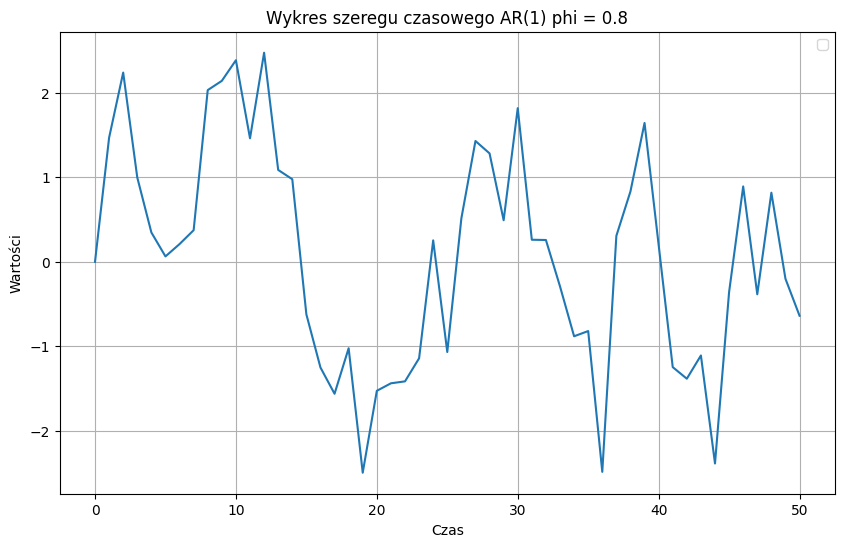

In [ ]:
def plot_time_series(data):
    plt.figure(figsize=(10, 6))
    plt.plot(data)
    plt.title('Wykres szeregu czasowego AR(1) phi = 0.8')
    plt.xlabel('Czas')
    plt.ylabel('Wartości')
    plt.legend()
    plt.grid(True)
    plt.show()

data_to_print = generate_ar1(50, 0.8, 1, 0)

plot_time_series(data_to_print)

In [66]:
tables_ar1_to_ar3 = [ar1_to_ar3_n50_phi08, 
          ar1_to_ar3_n50_phimin08,
          ar1_to_ar3_n50_phi_01,
          ar1_to_ar3_n50_phi_min01,
          ar1_to_ar3_n100_phi08,
          ar1_to_ar3_n100_phimin08,
          ar1_to_ar3_n100_phi_01,
          ar1_to_ar3_n100_phi_min01,
          ar1_to_ar3_n1000_phi08,
          ar1_to_ar3_n1000_phimin08,
          ar1_to_ar3_n1000_phi_01,
          ar1_to_ar3_n1000_phi_min01]

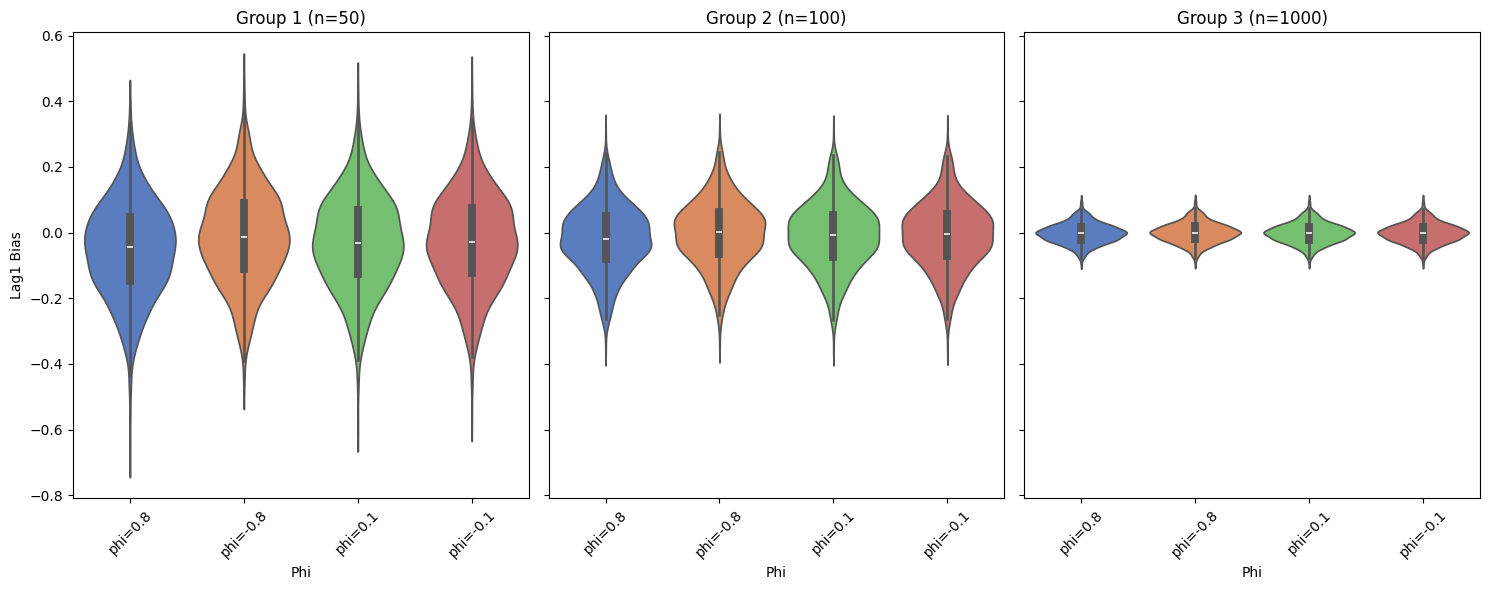

In [ ]:
phi_labels = ["phi=0.8", "phi=-0.8", "phi=0.1", "phi=-0.1"]

groups = {
    "Group 1 (n=50)": tables_ar1_to_ar3[:4],
    "Group 2 (n=100)": tables_ar1_to_ar3[4:8],
    "Group 3 (n=1000)": tables_ar1_to_ar3[8:]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, (group_name, group_tables) in zip(axes, groups.items()):
    group_data = pd.concat([
        table.assign(Phi=phi_label) for table, phi_label in zip(group_tables, phi_labels)
    ], ignore_index=True)
    
    sns.violinplot(data=group_data, x="Phi", y="Lag1_Bias", palette="muted", ax=ax)
    ax.set_title(group_name)
    ax.set_xlabel("Phi")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

axes[0].set_ylabel("Lag1 Bias")

plt.tight_layout()
plt.show()


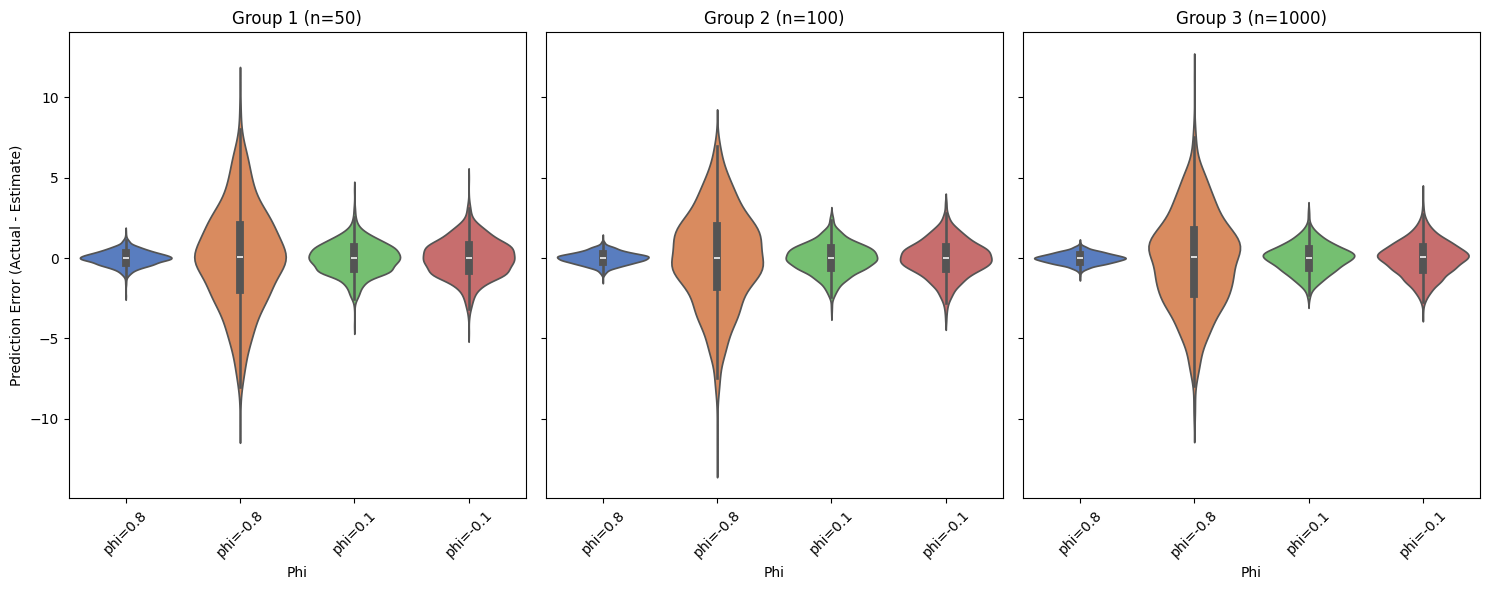

In [ ]:
phi_labels = ["phi=0.8", "phi=-0.8", "phi=0.1", "phi=-0.1"]

groups = {
    "Group 1 (n=50)": tables_ar1_to_ar3[:4],
    "Group 2 (n=100)": tables_ar1_to_ar3[4:8],
    "Group 3 (n=1000)": tables_ar1_to_ar3[8:]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, (group_name, group_tables) in zip(axes, groups.items()):
    group_data = pd.concat([
        table.assign(Phi=phi_label, Error=table["Actual_value"] - table["Next_Value_Estimate"])
        for table, phi_label in zip(group_tables, phi_labels)
    ], ignore_index=True)
    
    sns.violinplot(data=group_data, x="Phi", y="Error", palette="muted", ax=ax)
    ax.set_title(group_name)
    ax.set_xlabel("Phi")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

axes[0].set_ylabel("Prediction Error (Actual - Estimate)")

plt.tight_layout()
plt.show()


In [ ]:
#@title AR(3) -> AR(1) Function
def generate_ar3(N, phi1, phi2, phi3, sigma, initial_value):
    ar3_values = np.zeros(N+3)  # Potrzebujemy 3 początkowych wartości dla AR(3)
    ar3_values[0] = initial_value
    for i in range(3, N+3):
        ar3_values[i] = phi1 * ar3_values[i - 1] + phi2 * ar3_values[i - 2] + phi3 * ar3_values[i - 3] + np.random.normal(0, sigma)
    return ar3_values

def ar1_analysis_from_ar3(N, phi1, phi2, phi3, sigma=1, initial_value=0):
    data = np.zeros((N+3, 1000))  
    for i in range(1000):
        np.random.seed(i)
        data[:, i] = generate_ar3(N, phi1, phi2, phi3, sigma, initial_value)

    ar3_dataframe = pd.DataFrame(data)
    actual_value = pd.DataFrame(ar3_dataframe.tail(1))
    actual_value = actual_value.transpose()
    actual_value = actual_value.rename(columns={actual_value.columns[0]: 'Actual_value'})

    ar3_dataframe.drop(ar3_dataframe.tail(1).index, inplace=True)

    # Inicjalizacja tablic na wyniki
    param_estimates = []
    std_errors = []
    ljungbox_stats = {lag: [] for lag in range(1, 2)}  
    ljungbox_pvalues = {lag: [] for lag in range(1, 2)} 
    basic_stats = {'mean': [], 'min': [], 'max': [], 'median': [], 'skewness': [], 'kurtosis': []}
    bias_test = {'Intercept_Bias': [], 'Lag1_Bias': []} 
    normality_test_pvalues = []  
    significance_tests = {'Lag1_pvalue': []} 
    next_value_estimates = []  
    stationarity_pvalues = [] 

    true_params = {'Intercept': 0, 'Lag1': phi1}  # Parametry modelu AR(1)

    # Estymacja modelu AR(1) dla każdej kolumny
    for i in range(1000):
        model = sm.tsa.AutoReg(data[:, i], lags=1)  # Używamy AR(1)
        results = model.fit()

        # Zapisujemy wartości parametrów i ich odchylenia standardowe
        param_estimates.append(results.params)
        std_errors.append(results.bse)

        # Obliczanie obciążenia estymatorów
        params_dict = dict(zip(['Intercept', 'Lag1'], results.params))
        for param_name, true_value in true_params.items():
            bias_test[f'{param_name}_Bias'].append(params_dict[param_name] - true_value)

        # Reszty modelu
        residuals = results.resid

        # Test Ljung-Box dla reszt (dla opóźnienia 1)
        lb_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
        ljungbox_stats[1].append(lb_test.iloc[0]['lb_stat'])
        ljungbox_pvalues[1].append(lb_test.iloc[0]['lb_pvalue'])

        # Test normalności reszt (Shapiro-Wilk)
        stat, p_value = shapiro(residuals)
        normality_test_pvalues.append(p_value)

        # Obliczenie podstawowych statystyk
        basic_stats['mean'].append(np.mean(data[:, i]))
        basic_stats['min'].append(np.min(data[:, i]))
        basic_stats['max'].append(np.max(data[:, i]))
        basic_stats['median'].append(np.median(data[:, i]))
        basic_stats['skewness'].append(skew(data[:, i]))
        basic_stats['kurtosis'].append(kurtosis(data[:, i]))

        # Testy istotności parametrów dla Lag1
        significance_tests['Lag1_pvalue'].append(results.pvalues[1])  

        # Estymacja kolejnego wyrazu w szeregu czasowym (Y_t+1)
        lag1 = data[-1, i]  
        next_value = results.params[0] + results.params[1] * lag1  
        next_value_estimates.append(next_value)

        # Test ADF na stacjonarność
        adf_test = adfuller(data[:, i])
        stationarity_pvalues.append(adf_test[1])  

    param_estimates_df = pd.DataFrame(param_estimates, columns=['Intercept', 'Lag1'])
    std_errors_df = pd.DataFrame(std_errors, columns=['Intercept_SE', 'Lag1_SE'])

    ljungbox_df = pd.DataFrame({
        f'LB_Stat_Lag{lag}': ljungbox_stats[lag] for lag in range(1, 2)
    })
    ljungbox_df_pvalues = pd.DataFrame({
        f'LB_PValue_Lag{lag}': ljungbox_pvalues[lag] for lag in range(1, 2)
    })

    basic_stats_df = pd.DataFrame(basic_stats)
    bias_test_df = pd.DataFrame(bias_test)
    normality_test_df = pd.DataFrame({'Normality_PValue': normality_test_pvalues})
    significance_tests_df = pd.DataFrame(significance_tests)
    next_value_df = pd.DataFrame({'Next_Value_Estimate': next_value_estimates})
    stationarity_df = pd.DataFrame({'Stationarity_PValue': stationarity_pvalues})

    results_df = pd.concat([param_estimates_df, std_errors_df, ljungbox_df, ljungbox_df_pvalues,
                            basic_stats_df, bias_test_df, normality_test_df, significance_tests_df,
                            stationarity_df, actual_value, next_value_df], axis=1)

    return results_df

In [50]:
#@title AR(3)->AR(1) N=50 phi1=0.8 phi2=-0.3 phi3=-0.2
N = 50
phi1 = 0.8
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n50_phi08 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n50_phi08

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.041536,0.640771,0.204213,0.108223,8.724365,0.003140,0.171101,-4.044474,3.766953,0.348059,-0.401762,-0.336636,0.041536,-0.159229,0.759349,3.203007e-09,3.737901e-08,-1.713206,-1.056236
1,0.006811,0.546314,0.145207,0.117531,1.607072,0.204904,-0.010973,-2.528839,2.620927,0.118025,-0.041313,-0.719264,0.006811,-0.253686,0.583128,3.347695e-06,4.509083e-02,1.131267,0.624838
2,-0.120085,0.460781,0.148830,0.124287,1.259789,0.261691,-0.197990,-2.322907,2.878649,-0.416758,0.821583,0.575690,-0.120085,-0.339219,0.008901,2.093982e-04,1.776427e-05,-1.272124,-0.706257
3,-0.166803,0.635837,0.175288,0.107581,7.946828,0.004817,-0.404044,-4.190346,2.904239,-0.397007,0.012113,-0.305138,-0.166803,-0.164163,0.685570,3.415066e-09,2.362268e-07,-1.376836,-1.042246
4,0.034235,0.581713,0.157764,0.112935,3.426089,0.064174,0.067870,-2.318797,3.549414,0.058360,0.397308,-0.224527,0.034235,-0.218287,0.746038,2.592670e-07,7.504651e-04,0.473716,0.309802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.053138,0.561796,0.156222,0.114730,3.155478,0.075673,-0.119701,-3.043118,3.029217,-0.284246,0.218434,-0.464782,-0.053138,-0.238204,0.577110,9.746124e-07,2.172897e-06,0.030037,-0.036263
996,0.015342,0.619426,0.152060,0.113139,3.072442,0.079630,-0.025068,-2.299107,3.550280,-0.246280,0.767437,-0.060491,0.015342,-0.180574,0.071540,4.377467e-08,1.828547e-03,2.104283,1.318789
997,-0.079449,0.644525,0.205448,0.106206,10.703372,0.001069,-0.190932,-4.692372,5.146756,-0.082621,0.100505,0.414355,-0.079449,-0.155475,0.180696,1.290062e-09,2.419523e-09,-0.828709,-0.613572
998,-0.084646,0.682567,0.157554,0.101311,8.990293,0.002714,-0.246661,-3.412915,3.254138,0.000000,-0.141250,-0.337288,-0.084646,-0.117433,0.399439,1.612793e-11,1.492665e-06,-0.368865,-0.336421


In [51]:
#@title AR(3)->AR(1) N=50 phi1=-0.8 phi2=-0.3 phi3=-0.2
N = 50
phi1 = -0.8
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n50_phimin08 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n50_phimin08

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.093654,-0.690368,0.152181,0.103469,0.064300,0.799824,0.069678,-3.307065,3.086473,0.000000,-0.062019,-0.375425,0.093654,0.109632,0.902105,2.520027e-11,6.224959e-29,1.987963,-1.278771
1,-0.021241,-0.845588,0.133788,0.075313,0.193454,0.660057,-0.000345,-4.413042,4.326613,0.000000,-0.137460,0.107004,-0.021241,-0.045588,0.247616,2.983862e-29,9.440872e-11,1.266246,-1.091963
2,-0.103855,-0.727894,0.148380,0.095638,2.065006,0.150714,-0.052881,-4.442011,3.763581,-0.032662,-0.076212,1.178615,-0.103855,0.072106,0.705273,2.720897e-14,2.447653e-06,0.766212,-0.661576
3,-0.192241,-0.532855,0.140293,0.120839,0.443510,0.505433,-0.112540,-2.535648,1.915515,-0.062193,-0.007263,-0.777061,-0.192241,0.267145,0.148964,1.035517e-05,2.740616e-10,1.602065,-1.045910
4,0.033116,-0.796422,0.137457,0.087094,0.234551,0.628170,0.034359,-3.843769,3.675626,0.000000,-0.090103,-0.374902,0.033116,0.003578,0.535133,5.997615e-20,1.636028e-04,1.945408,-1.516250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.068129,-0.806023,0.138720,0.087780,0.137927,0.710351,-0.058841,-3.099466,3.712890,0.000000,0.147722,-0.782383,-0.068129,-0.006023,0.152250,4.221232e-20,6.399795e-09,-2.592401,2.021405
996,-0.018884,-0.543836,0.146985,0.116642,2.053723,0.151835,-0.015508,-2.793271,4.588095,-0.193339,0.852510,2.342579,-0.018884,0.256164,0.004575,3.124723e-06,2.975354e-24,-0.527651,0.268072
997,-0.084277,-0.486552,0.150934,0.122605,0.332088,0.564432,-0.048563,-2.372496,2.150761,-0.068086,0.087554,-1.006723,-0.084277,0.313448,0.630954,7.234615e-05,5.922621e-22,1.143190,-0.640498
998,-0.127404,-0.405407,0.125595,0.127356,0.221444,0.637942,-0.086015,-3.112424,2.134778,0.000000,-0.242496,0.941328,-0.127404,0.394593,0.976510,1.456260e-03,1.806013e-19,0.537804,-0.345433


In [52]:
#@title AR(3)->AR(1) N=50 phi1=0.1 phi2=-0.3 phi3=-0.2
N = 50
phi1 = 0.1
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n50_phi01 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n50_phi01

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.072469,0.209479,0.156980,0.135649,0.081984,0.774627,0.090679,-2.581239,2.342593,-0.050516,0.014148,-0.610298,0.072469,0.109479,0.575164,0.122523,1.657245e-05,-0.147315,0.041609
1,-0.005923,-0.032002,0.141339,0.138641,0.003644,0.951867,-0.005536,-1.813970,2.228954,-0.215338,0.453382,-0.647727,-0.005923,-0.132002,0.054445,0.817450,2.532784e-03,0.163087,-0.011143
2,-0.101194,0.000921,0.156607,0.138744,0.000002,0.998907,-0.099379,-2.307557,2.857855,-0.097943,0.462225,0.304667,-0.101194,-0.099079,0.267206,0.994702,2.763323e-09,0.172177,-0.101035
3,-0.177745,0.191776,0.153211,0.136122,0.354002,0.551856,-0.213683,-2.443686,2.364170,-0.391679,0.320335,-0.398506,-0.177745,0.091776,0.590104,0.158877,8.350253e-10,-0.466406,-0.267191
4,0.031941,0.046942,0.146427,0.138885,0.007832,0.929482,0.032344,-2.338277,3.168428,0.000000,0.202354,0.283126,0.031941,-0.053058,0.658818,0.735368,1.981553e-09,0.577821,0.059065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.052521,0.054290,0.144969,0.138538,0.008482,0.926619,-0.054171,-2.071799,3.028133,-0.036018,0.489344,0.377182,-0.052521,-0.045710,0.393716,0.695147,9.549365e-08,-0.292880,-0.068422
996,-0.011734,0.071306,0.147513,0.138564,0.040732,0.840056,-0.013028,-2.313739,3.180086,-0.079123,0.386531,0.759061,-0.011734,-0.028694,0.376400,0.606826,5.292758e-10,0.435963,0.019353
997,-0.071909,0.281335,0.170443,0.133093,0.924636,0.336261,-0.096155,-2.962481,3.238198,0.000000,0.162226,0.128703,-0.071909,0.181335,0.507358,0.034530,8.515351e-07,-0.273107,-0.148744
998,-0.113949,0.293971,0.140340,0.134527,0.961823,0.326728,-0.147483,-2.190158,2.350565,0.000000,0.090595,-0.466491,-0.113949,0.193971,0.701972,0.028873,4.496376e-09,-1.383188,-0.520566


In [53]:
#@title AR(3)->AR(1) N=50 phi1=-0.1 phi2=-0.3 phi3=-0.2
N = 50
phi1 = -0.1
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n50_phimin01 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n50_phimin01

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.078936,0.011144,0.153307,0.138724,0.000081,0.992797,0.078354,-2.312253,2.509975,0.010551,0.090233,-0.629713,0.078936,0.111144,0.452711,0.935972,8.826809e-05,-0.162407,0.077126
1,-0.010304,-0.188550,0.141689,0.136197,0.098241,0.753950,-0.008789,-2.137050,2.453863,-0.094539,0.470843,-0.210156,-0.010304,-0.088550,0.095761,0.166239,1.071227e-03,-0.094539,0.007522
2,-0.099219,-0.141977,0.155293,0.137368,0.126595,0.721989,-0.084711,-2.821264,2.594250,-0.014591,0.189243,0.246821,-0.099219,-0.041977,0.369297,0.301345,1.248426e-09,0.227242,-0.131482
3,-0.179043,0.054373,0.150953,0.138452,0.023238,0.878841,-0.185715,-2.251927,2.208234,-0.141744,0.254426,-0.385914,-0.179043,0.154373,0.442823,0.694524,1.747268e-10,-0.047022,-0.181600
4,0.032676,-0.127074,0.144552,0.138084,0.037028,0.847408,0.029900,-2.488474,2.758361,0.153249,0.001366,-0.036165,0.032676,-0.027074,0.592520,0.357433,7.842926e-10,0.684101,-0.054255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.056667,-0.128883,0.142779,0.138198,0.031703,0.858680,-0.050931,-1.722931,2.823923,-0.025959,0.514337,0.033392,-0.056667,-0.028883,0.209266,0.351027,7.313965e-08,-0.780468,0.043922
996,-0.014171,-0.068133,0.148519,0.138448,0.041289,0.838980,-0.012690,-2.599629,3.659368,0.000000,0.444265,1.964233,-0.014171,0.031867,0.156247,0.622636,2.938194e-11,0.271814,-0.032691
997,-0.074778,0.137291,0.161667,0.137356,0.133478,0.714852,-0.084872,-2.941710,2.968234,-0.056788,0.140239,0.056200,-0.074778,0.237291,0.761816,0.317538,6.754572e-07,-0.056788,-0.082575
998,-0.117136,0.168537,0.135128,0.137960,0.222194,0.637373,-0.134095,-2.216461,1.952969,0.000000,0.045885,-0.308007,-0.117136,0.268537,0.778736,0.221844,5.436257e-09,-1.078707,-0.298938


In [54]:
#@title AR(3)->AR(1) N=100 phi1=0.8 phi2=-0.3 phi3=-0.2
N = 100
phi1 = 0.8
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n100_phi08 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n100_phi08

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.037522,0.637232,0.120143,0.076431,12.077149,0.000510,0.089026,-4.044474,3.766953,0.007307,-0.202481,0.115136,0.037522,-0.162768,0.965465,7.597990e-17,4.153908e-01,0.785883,0.538312
1,0.037324,0.575400,0.104862,0.081012,9.160871,0.002472,0.081993,-3.369008,3.554372,0.149010,-0.057730,-0.093515,0.037324,-0.224600,0.408288,1.223777e-12,4.471285e-13,0.384410,0.258514
2,-0.080471,0.426010,0.102147,0.090283,1.321376,0.250345,-0.128608,-2.322907,2.878649,-0.143993,0.378309,-0.029300,-0.080471,-0.373990,0.199220,2.374699e-06,1.058066e-08,-1.419277,-0.685097
3,-0.047212,0.656437,0.125077,0.075432,11.493927,0.000698,-0.165789,-4.190346,3.000995,-0.012784,-0.176315,-0.341244,-0.047212,-0.143563,0.889525,3.249361e-18,5.556360e-11,1.601381,1.003994
4,0.009999,0.612658,0.109700,0.078531,6.857378,0.008828,0.039265,-3.532692,3.549414,0.050562,0.199117,-0.131810,0.009999,-0.187342,0.467899,6.120112e-15,1.672597e-11,-0.892300,-0.536676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.028187,0.613019,0.111652,0.078484,9.392857,0.002178,-0.057164,-3.279911,3.186908,-0.265923,0.113644,-0.502881,-0.028187,-0.186981,0.894744,5.686409e-15,1.182285e-12,-0.973097,-0.624714
996,0.080701,0.650220,0.111155,0.075261,7.895049,0.004957,0.231690,-2.835880,4.323825,0.000000,0.454583,-0.136851,0.080701,-0.149780,0.086213,5.642708e-18,1.217918e-08,-0.177953,-0.035008
997,0.006698,0.643034,0.126446,0.076001,16.211629,0.000057,0.033102,-4.692372,5.146756,-0.058223,0.059537,0.772274,0.006698,-0.156966,0.222748,2.654483e-17,8.258259e-07,-0.830316,-0.527224
998,0.014582,0.643641,0.116650,0.075865,9.248956,0.002356,0.049590,-3.412915,3.748549,0.110327,-0.065919,-0.294560,0.014582,-0.156359,0.088008,2.175658e-17,1.064391e-08,-0.517116,-0.318255


In [55]:
#@title AR(3)->AR(1) N=100 phi1=-0.8 phi2=-0.3 phi3=-0.2
N = 100
phi1 = -0.8
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n100_phimin08 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n100_phimin08

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.043723,-0.697222,0.098067,0.071548,0.197683,0.656598,0.030632,-3.307065,3.086473,0.000000,0.060615,-0.524269,0.043723,0.102778,0.910689,1.942472e-22,0.000000e+00,1.283906,-0.851444
1,0.046420,-0.775261,0.089658,0.063056,0.000006,0.997999,0.030947,-4.413042,4.326613,0.033414,-0.255371,1.235075,0.046420,0.024739,0.607128,9.671509e-35,7.649254e-17,1.191622,-0.877397
2,-0.079749,-0.717326,0.106592,0.071060,6.101531,0.013506,-0.056737,-4.682318,3.763581,0.000000,-0.183292,1.048467,-0.079749,0.082674,0.743406,5.832391e-24,6.528115e-04,-2.650829,1.821760
3,-0.071545,-0.664363,0.105348,0.075700,0.375524,0.540008,-0.033986,-3.241972,3.340107,0.000000,-0.006104,-0.501204,-0.071545,0.135637,0.631080,1.689295e-18,0.000000e+00,2.214664,-1.542887
4,0.025661,-0.734811,0.097246,0.067470,1.057052,0.303888,0.018618,-3.843769,3.675626,0.000000,-0.021690,-0.189912,0.025661,0.065189,0.651059,1.273393e-27,0.000000e+00,0.965458,-0.683768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.025185,-0.771628,0.095093,0.063412,0.036907,0.847655,-0.009368,-3.099466,3.712890,0.000000,0.064657,-0.693581,-0.025185,0.028372,0.262835,4.570254e-34,3.405732e-15,1.113893,-0.884697
996,0.111105,-0.573153,0.103241,0.081588,1.317030,0.251126,0.066284,-3.021718,4.588095,0.000000,0.455421,0.996866,0.111105,0.226847,0.012874,2.141044e-12,0.000000e+00,-1.033431,0.703419
997,0.002660,-0.549876,0.101169,0.088587,0.700857,0.402496,-0.011013,-3.690654,2.150761,0.000000,-0.189495,-0.395826,0.002660,0.250124,0.999177,5.394096e-10,8.375626e-09,-3.690654,2.032064
998,0.023887,-0.630767,0.103422,0.077190,0.530682,0.466320,0.018365,-3.989155,5.571108,0.082450,0.114155,2.455377,0.023887,0.169233,0.754034,3.043339e-16,0.000000e+00,1.027670,-0.624334


In [56]:
#@title AR(3)->AR(1) N=100 phi1=0.1 phi2=-0.3 phi3=-0.2
N = 100
phi1 = 0.1
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n100_phi01 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n100_phi01

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.036927,0.171107,0.100225,0.097557,0.093688,0.759540,0.044206,-2.581239,2.342593,0.000000,0.043733,-0.275712,0.036927,0.071107,0.757133,0.079446,3.008404e-10,-0.044464,0.029319
1,0.036843,0.144980,0.100434,0.098227,0.308344,0.578698,0.041386,-2.760192,2.228954,0.000000,-0.057728,-0.252228,0.036843,0.044980,0.471919,0.139952,1.953515e-19,0.780950,0.150065
2,-0.078887,-0.050799,0.108532,0.101243,0.031830,0.858400,-0.075488,-2.436563,2.857855,-0.095876,0.082018,0.005954,-0.078887,-0.150799,0.453152,0.615837,5.970611e-05,-2.436563,0.044889
3,-0.058796,0.152737,0.109079,0.099893,0.162055,0.687271,-0.072479,-3.359528,2.364170,-0.098628,0.018953,-0.105364,-0.058796,0.052737,0.611487,0.126263,3.629757e-13,2.146483,0.269050
4,0.020433,0.077393,0.101211,0.098823,0.036629,0.848223,0.021529,-2.338277,3.168428,0.000000,0.138346,0.253549,0.020433,-0.022607,0.756762,0.433539,2.491231e-13,0.494983,0.058741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.025376,0.119112,0.100243,0.098337,0.097562,0.754776,-0.028807,-2.071799,3.028133,0.000000,0.211071,-0.276086,-0.025376,0.019112,0.217427,0.225796,3.396534e-14,0.213492,0.000054
996,0.100807,0.136646,0.105339,0.098317,0.210674,0.646240,0.116583,-2.313739,3.180086,0.000000,0.425338,0.263811,0.100807,0.036646,0.114920,0.164577,2.797447e-15,-0.620951,0.015957
997,0.004665,0.227671,0.108657,0.097922,0.816818,0.366112,0.011463,-2.962481,3.238198,0.027687,-0.006277,0.266624,0.004665,0.127671,0.941469,0.020070,1.198277e-05,-1.915471,-0.431433
998,0.020606,0.173097,0.110646,0.097565,0.348961,0.554702,0.023932,-2.357767,2.569366,0.081490,0.053887,-0.516798,0.020606,0.073097,0.803325,0.076036,3.807999e-12,0.366728,0.084085


In [57]:
#@title AR(3)->AR(1) N=100 phi1=-0.1 phi2=-0.3 phi3=-0.2
N = 100
phi1 = -0.1
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n100_phimin01 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n100_phimin01

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,0.038977,-0.018566,0.098756,0.098999,0.000619,0.980149,0.037889,-2.312253,2.509975,0.018976,0.078131,-0.412054,0.038977,0.081434,0.589514,0.851240,7.533551e-10,-0.031413,0.039560
1,0.039069,-0.015486,0.096937,0.099385,0.001867,0.965537,0.038233,-2.591498,2.453863,0.000000,-0.016714,0.090499,0.039069,0.084514,0.744915,0.876178,2.862709e-19,0.901031,0.025116
2,-0.079366,-0.192456,0.108254,0.099671,0.422925,0.515481,-0.069856,-2.821264,2.594250,-0.013192,-0.143112,-0.052440,-0.079366,-0.092456,0.501792,0.053495,1.924270e-05,-2.518018,0.405242
3,-0.061239,-0.009905,0.108196,0.101443,0.000539,0.981471,-0.059829,-3.042473,2.324380,0.000000,0.040030,-0.242641,-0.061239,0.090095,0.647466,0.922217,2.870003e-14,2.324380,-0.084262
4,0.022490,-0.095760,0.099929,0.098748,0.039513,0.842436,0.020875,-2.488474,2.758361,0.050562,0.036339,0.018782,0.022490,0.004240,0.794259,0.332176,1.409765e-13,0.647967,-0.039560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.024852,-0.058575,0.098485,0.099040,0.014292,0.904842,-0.022923,-1.743988,2.823923,0.000000,0.200127,-0.475801,-0.024852,0.041425,0.112241,0.554235,2.546504e-14,0.605356,-0.060311
996,0.102554,-0.007631,0.105571,0.099279,0.000704,0.978825,0.100739,-2.599629,3.659368,0.000000,0.548052,1.094053,0.102554,0.092369,0.025545,0.938730,4.134431e-17,-0.687054,0.107797
997,0.003613,0.074785,0.105110,0.101385,0.059573,0.807171,0.005763,-2.941710,2.968234,-0.014135,-0.081702,0.165922,0.003613,0.174785,0.977102,0.460736,1.363621e-05,-2.415591,-0.177038
998,0.020745,0.019254,0.108164,0.099045,0.002763,0.958079,0.020878,-2.344998,2.760110,0.000000,0.046109,-0.310228,0.020745,0.119254,0.934464,0.845864,2.616550e-12,0.365272,0.027778


In [58]:
#@title AR(3)->AR(1) N=1000 phi1=0.8 phi2=-0.3 phi3=-0.2
N = 1000
phi1 = 0.8
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n1000_phi08 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n1000_phi08

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,-0.026315,0.607282,0.036603,0.025120,85.533439,2.278163e-20,-0.064508,-4.255407,4.506712,-0.130112,0.058671,-0.041620,-0.026315,-0.192718,0.901641,4.071120e-129,6.150873e-22,-1.577262,-0.984157
1,0.021755,0.593768,0.035680,0.025420,73.424404,1.045652e-17,0.053591,-5.290231,4.045005,0.065144,-0.204459,0.179131,0.021755,-0.206232,0.598668,1.123422e-120,0.000000e+00,-0.062010,-0.015064
2,-0.028018,0.593456,0.037116,0.025428,82.230267,1.211208e-19,-0.068209,-5.009469,4.939724,-0.129890,0.163693,0.118184,-0.028018,-0.206544,0.082730,1.792953e-120,0.000000e+00,-0.438952,-0.288516
3,0.010606,0.606799,0.037618,0.025119,89.499738,3.066791e-21,0.025425,-4.190346,5.194013,0.039694,0.012491,-0.013444,0.010606,-0.193201,0.716786,6.257460e-129,5.072710e-22,0.988829,0.610626
4,0.030187,0.597373,0.034952,0.025335,83.261551,7.188425e-20,0.075073,-3.532692,4.236598,0.031744,0.107648,-0.164753,0.030187,-0.202627,0.249695,6.380239e-123,0.000000e+00,-0.116397,-0.039345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001514,0.607678,0.035148,0.025092,59.542325,1.196920e-14,0.003071,-4.106929,4.525211,-0.000734,0.019724,-0.257539,0.001514,-0.192322,0.734026,1.431165e-129,0.000000e+00,0.507919,0.310165
996,0.001077,0.619595,0.039063,0.024843,100.245996,1.345972e-23,-0.001063,-5.097303,4.512531,-0.099229,0.139909,-0.130308,0.001077,-0.180405,0.008702,2.732139e-137,0.000000e+00,2.395652,1.485411
997,0.014971,0.602983,0.035550,0.025203,92.017239,8.592469e-22,0.038105,-4.692372,5.146756,0.008501,-0.065680,0.200164,0.014971,-0.197017,0.681441,1.681339e-126,1.051802e-18,-0.286840,-0.157989
998,0.004511,0.612671,0.036280,0.024969,92.465417,6.851158e-22,0.010942,-3.824776,4.490362,0.000000,0.114027,-0.090144,0.004511,-0.187329,0.688785,5.979529e-133,0.000000e+00,0.439834,0.273985


In [59]:
#@title AR(3)->AR(1) N=1000 phi1=-0.8 phi2=-0.3 phi3=-0.2
N = 1000
phi1 = -0.8
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n1000_phimin08 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n1000_phimin08

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,-0.033022,-0.669471,0.031982,0.023474,16.239038,0.000056,-0.019453,-4.451820,4.043701,-0.027449,0.023241,-0.121001,-0.033022,0.130529,0.309511,6.733459e-179,0.000000e+00,0.766650,-0.546271
1,0.028993,-0.713504,0.032000,0.022135,7.102018,0.007700,0.016822,-4.413042,5.153619,0.043105,-0.006573,-0.097031,0.028993,0.086496,0.242509,5.837653e-228,0.000000e+00,-0.196737,0.169366
2,-0.035117,-0.693068,0.032751,0.022773,8.608993,0.003345,-0.020746,-5.260443,5.296522,-0.061220,0.023868,0.533399,-0.035117,0.106932,0.011524,1.984776e-203,0.000000e+00,-0.061220,0.007313
3,0.012754,-0.690226,0.032851,0.022902,9.852778,0.001696,0.006722,-4.667053,4.525892,0.015576,-0.013229,-0.000603,0.012754,0.109774,0.949181,1.532405e-199,0.000000e+00,-2.004325,1.396190
4,0.037161,-0.673573,0.031303,0.023416,9.111541,0.002540,0.021244,-4.013677,4.207620,0.056153,0.029005,-0.192609,0.037161,0.126427,0.849865,5.837275e-182,0.000000e+00,-2.339538,1.613011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001555,-0.736304,0.031988,0.021377,7.231086,0.007165,0.000789,-4.625086,4.056548,-0.031512,0.039472,-0.147249,0.001555,0.063696,0.155602,5.551138e-260,0.000000e+00,-0.251126,0.186460
996,0.000509,-0.645359,0.034030,0.024142,9.172016,0.002457,0.000689,-4.212327,4.588095,-0.001699,0.010349,-0.123418,0.000509,0.154641,0.024547,1.990600e-157,0.000000e+00,0.970950,-0.626102
997,0.019630,-0.674326,0.031083,0.023384,6.135958,0.013246,0.010854,-3.886481,4.078512,0.012430,0.033495,-0.245852,0.019630,0.125674,0.647829,7.323138e-183,1.847989e-23,-2.139124,1.462097
998,0.004949,-0.660753,0.032183,0.023784,5.386503,0.020293,0.001986,-4.091995,5.571108,0.005453,0.055073,0.194646,0.004949,0.139247,0.938052,7.326213e-170,0.000000e+00,-2.499620,1.656581


In [60]:
#@title AR(3)->AR(1) N=1000 phi1=0.1 phi2=-0.3 phi3=-0.2
N = 1000
phi1 = 0.1
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n1000_phi01 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n1000_phi01

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,-0.029557,0.100083,0.032826,0.031434,0.794996,0.372594,-0.032773,-3.438412,2.811527,-0.055494,-0.013262,-0.208059,-0.029557,0.000083,0.260705,1.453048e-03,0.000000e+00,-0.342983,-0.063884
1,0.025218,0.108601,0.033711,0.031409,1.226013,0.268184,0.028184,-3.140433,3.456588,0.080404,-0.077504,-0.067773,0.025218,0.008601,0.375370,5.450571e-04,0.000000e+00,0.639139,0.094629
2,-0.029896,0.120388,0.034752,0.031364,1.686034,0.194125,-0.034003,-2.982064,3.733024,-0.044345,0.150133,0.051097,-0.029896,0.020388,0.053958,1.237986e-04,0.000000e+00,0.367486,0.014345
3,0.011234,0.120365,0.034523,0.031364,1.550361,0.213082,0.012815,-3.359528,3.508803,0.012487,0.016589,-0.165758,0.011234,0.020365,0.872542,1.242005e-04,0.000000e+00,-0.414800,-0.038693
4,0.031351,0.125796,0.033026,0.031368,2.103664,0.146947,0.036021,-3.256950,3.168428,0.051988,0.013854,-0.109677,0.031351,0.025796,0.726252,6.063315e-05,0.000000e+00,-1.353266,-0.138884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001613,0.088090,0.033132,0.031469,0.499942,0.479526,0.001782,-3.312642,4.427138,0.000000,0.150255,0.162344,0.001613,-0.011910,0.147823,5.121692e-03,0.000000e+00,-0.159094,-0.012402
996,0.000766,0.141347,0.035691,0.031349,2.449176,0.117587,0.000486,-3.257541,3.682593,-0.030312,0.176870,-0.107306,0.000766,0.041347,0.012031,6.520130e-06,0.000000e+00,2.474025,0.350461
997,0.016359,0.156472,0.033442,0.031203,3.248085,0.071507,0.019409,-4.020494,3.238198,0.040373,-0.054189,-0.008997,0.016359,0.056472,0.777452,5.311744e-07,1.064447e-25,-0.189298,-0.013261
998,0.004458,0.148096,0.034296,0.031251,3.152671,0.075803,0.005360,-3.759541,3.359465,0.045086,-0.019619,-0.070361,0.004458,0.048096,0.539223,2.147994e-06,0.000000e+00,-0.766032,-0.108989


In [61]:
#@title AR(3)->AR(1) N=1000 phi1=-0.1 phi2=-0.3 phi3=-0.2
N = 1000
phi1 = -0.1
phi2 = -0.3
phi3 = -0.2
ar3_to_ar1_n1000_phimin01 = ar1_analysis_from_ar3(N, phi1, phi2, phi3)
ar3_to_ar1_n1000_phimin01

,Intercept,Lag1,Intercept_SE,Lag1_SE,LB_Stat_Lag1,LB_PValue_Lag1,mean,min,max,median,skewness,kurtosis,Intercept_Bias,Lag1_Bias,Normality_PValue,Lag1_pvalue,Stationarity_PValue,Actual_value,Next_Value_Estimate
0,-0.030496,-0.065427,0.032532,0.031524,0.289486,0.590550,-0.028603,-3.182765,2.752992,-0.020169,0.010005,-0.215736,-0.030496,0.034573,0.159193,0.037942,0.000000e+00,-0.140309,-0.021316
1,0.025933,-0.051137,0.033217,0.031550,0.197229,0.656967,0.024655,-3.131405,3.863697,0.074220,-0.076293,0.042329,0.025933,0.048863,0.411919,0.105057,0.000000e+00,0.183375,0.016555
2,-0.030844,-0.036941,0.034152,0.031571,0.115462,0.734009,-0.029707,-2.896889,3.792027,-0.013125,0.160906,0.172072,-0.030844,0.063059,0.038995,0.241960,0.000000e+00,0.248501,-0.040024
3,0.011525,-0.040145,0.033941,0.031573,0.126878,0.721692,0.011041,-3.451924,3.292421,0.015178,0.020941,-0.176673,0.011525,0.059855,0.902917,0.203551,0.000000e+00,-0.730917,0.040868
4,0.032390,-0.026880,0.032522,0.031595,0.074405,0.785028,0.031486,-3.077208,3.077555,0.054873,0.004533,-0.080557,0.032390,0.073120,0.691110,0.394898,0.000000e+00,-0.970941,0.058489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001569,-0.082022,0.032757,0.031486,0.314738,0.574787,0.001428,-3.183969,4.342215,-0.031103,0.165697,0.049629,0.001569,0.017978,0.148486,0.009186,0.000000e+00,-0.276036,0.024210
996,0.000771,-0.011157,0.035227,0.031662,0.012155,0.912211,0.000788,-3.004800,3.659368,-0.055556,0.195195,-0.025074,0.000771,0.088843,0.013817,0.724547,0.000000e+00,2.393428,-0.025933
997,0.016977,-0.000667,0.032550,0.031596,0.000039,0.995037,0.016949,-3.714013,2.968234,0.016383,-0.042682,-0.046837,0.016977,0.099333,0.750341,0.983160,3.084117e-25,-0.555733,0.017348
998,0.004518,0.001721,0.033746,0.031609,0.000319,0.985745,0.004524,-4.213983,3.072449,0.023687,-0.046335,-0.058447,0.004518,0.101721,0.497577,0.956589,0.000000e+00,-1.117108,0.002596


In [ ]:
def calculate_metrics_per_row(df, threshold):
    results = pd.DataFrame(columns=[
        'MAPE (%)', 'RMSE', 'odsetek obciążonych lag1','odsetek szeregów stacjonarnych',
        'odsetek rozkładów normalnych', 'autokorelacja reszt', 'różnica pierwszego parametru'
    ])

    for index, row in df.iterrows():
        row_result = {}

        row_result['MAPE (%)'] = np.abs((row['Actual_value'] - row['Next_Value_Estimate']) / row['Actual_value']) * 100

        row_result['RMSE'] = np.sqrt((row['Actual_value'] - row['Next_Value_Estimate'])**2)

        row_result['odsetek obciążonych lag1'] = 1 if abs(row['Lag1']) > 0.05 else 0

        row_result['odsetek szeregów stacjonarnych'] = 1 if row['Stationarity_PValue'] < 0.05 else 0

        row_result['odsetek rozkładów normalnych'] = 1 if row['Normality_PValue'] > 0.05 else 0

        ljungbox_columns = [col for col in df.columns if col.startswith('LB_Stat_Lag')]
        ljungbox_pvalues = row[ljungbox_columns]
        row_result['autokorelacja reszt'] = 1 if (ljungbox_pvalues < 0.05).any() else 0

        row_result['różnica pierwszego parametru'] = row['Lag1'] - threshold

        results = pd.concat([results, pd.DataFrame(row_result, index=[index])])

    avg_row = {
        'MAPE (%)': results['MAPE (%)'].mean(),
        'RMSE': results['RMSE'].mean(),
        'odsetek obciążonych lag1': results['odsetek obciążonych lag1'].sum(),
        'odsetek szeregów stacjonarnych': results['odsetek szeregów stacjonarnych'].sum(),
        'odsetek rozkładów normalnych': results['odsetek rozkładów normalnych'].sum(),
        'autokorelacja reszt': results['autokorelacja reszt'].sum(),
        'różnica pierwszego parametru': results['różnica pierwszego parametru'].mean()
    }

    results = pd.concat([results, pd.DataFrame(avg_row, index=['Średnia/Suma'])])

    return results

row_metrics_n50_phi08 = calculate_metrics_per_row(ar3_to_ar1_n50_phi08, threshold=0.8)
row_metrics_n50_phimin08 = calculate_metrics_per_row(ar3_to_ar1_n50_phimin08, threshold=-0.8)
row_metrics_n100_phi08 = calculate_metrics_per_row(ar3_to_ar1_n100_phi08, threshold=0.8)
row_metrics_n100_phimin08 = calculate_metrics_per_row(ar3_to_ar1_n100_phimin08, threshold=-0.8)
row_metrics_n1000_phi08 = calculate_metrics_per_row(ar3_to_ar1_n1000_phi08, threshold=0.8)
row_metrics_n1000_phimin08 = calculate_metrics_per_row(ar3_to_ar1_n1000_phimin08, threshold=-0.8)
row_metrics_n50_phi01 = calculate_metrics_per_row(ar3_to_ar1_n50_phi01, threshold=0.1)
row_metrics_n50_phimin01 = calculate_metrics_per_row(ar3_to_ar1_n50_phimin01, threshold=-0.1)
row_metrics_n100_phi01 = calculate_metrics_per_row(ar3_to_ar1_n100_phi01, threshold=0.1)
row_metrics_n100_phimin01 = calculate_metrics_per_row(ar3_to_ar1_n100_phimin01, threshold=-0.1)
row_metrics_n1000_phi01 = calculate_metrics_per_row(ar3_to_ar1_n1000_phi01, threshold=0.1)
row_metrics_n1000_phimin01 = calculate_metrics_per_row(ar3_to_ar1_n1000_phimin01, threshold=-0.1)

last_rows = [
    row_metrics_n50_phi08.iloc[-1],
    row_metrics_n50_phimin08.iloc[-1],
    row_metrics_n50_phi01.iloc[-1],
    row_metrics_n50_phimin01.iloc[-1],
    row_metrics_n100_phi08.iloc[-1],
    row_metrics_n100_phimin08.iloc[-1],
    row_metrics_n100_phi01.iloc[-1],
    row_metrics_n100_phimin01.iloc[-1],
    row_metrics_n1000_phi08.iloc[-1],
    row_metrics_n1000_phimin08.iloc[-1],
    row_metrics_n1000_phi01.iloc[-1],
    row_metrics_n1000_phimin01.iloc[-1]
]

In [63]:
last_rows

[MAPE (%)                          62.799552
 RMSE                               0.446662
 odsetek obciążonych lag1               1000
 odsetek szeregów stacjonarnych          926
 odsetek rozkładów normalnych            945
 autokorelacja reszt                       2
 różnica pierwszego parametru       -0.21228
 Name: Średnia/Suma, dtype: object,
 MAPE (%)                          211.861003
 RMSE                                1.889113
 odsetek obciążonych lag1                1000
 odsetek szeregów stacjonarnych           955
 odsetek rozkładów normalnych             936
 autokorelacja reszt                      112
 różnica pierwszego parametru        0.138272
 Name: Średnia/Suma, dtype: object,
 MAPE (%)                          160.137341
 RMSE                                0.753878
 odsetek obciążonych lag1                 778
 odsetek szeregów stacjonarnych           943
 odsetek rozkładów normalnych             943
 autokorelacja reszt                      466
 różnica pierws

In [71]:
tables_ar3_to_ar1 = [ar3_to_ar1_n50_phi08, 
                     ar3_to_ar1_n50_phimin08, 
                     ar3_to_ar1_n50_phi01, 
                     ar3_to_ar1_n50_phimin01, 
                     ar3_to_ar1_n100_phi08, 
                     ar3_to_ar1_n100_phimin08, 
                     ar3_to_ar1_n100_phi01, 
                     ar3_to_ar1_n100_phimin01,
                     ar3_to_ar1_n1000_phi08, 
                     ar3_to_ar1_n1000_phimin08, 
                     ar3_to_ar1_n1000_phi01, 
                     ar3_to_ar1_n1000_phimin01]

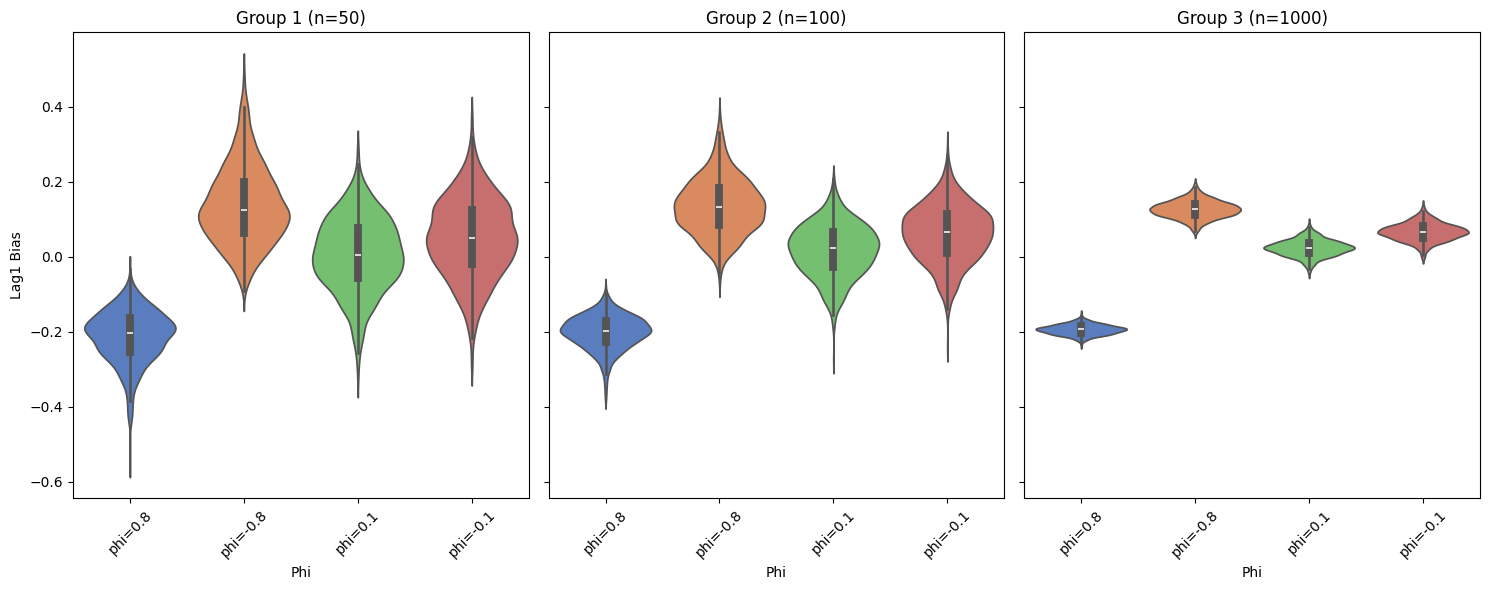

In [ ]:
phi_labels = ["phi=0.8", "phi=-0.8", "phi=0.1", "phi=-0.1"]

groups = {
    "Group 1 (n=50)": tables_ar3_to_ar1[:4],
    "Group 2 (n=100)": tables_ar3_to_ar1[4:8],
    "Group 3 (n=1000)": tables_ar3_to_ar1[8:]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, (group_name, group_tables) in zip(axes, groups.items()):
    group_data = pd.concat([
        table.assign(Phi=phi_label) for table, phi_label in zip(group_tables, phi_labels)
    ], ignore_index=True)

    sns.violinplot(data=group_data, x="Phi", y="Lag1_Bias", palette="muted", ax=ax)
    ax.set_title(group_name)
    ax.set_xlabel("Phi")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

axes[0].set_ylabel("Lag1 Bias")

plt.tight_layout()
plt.show()


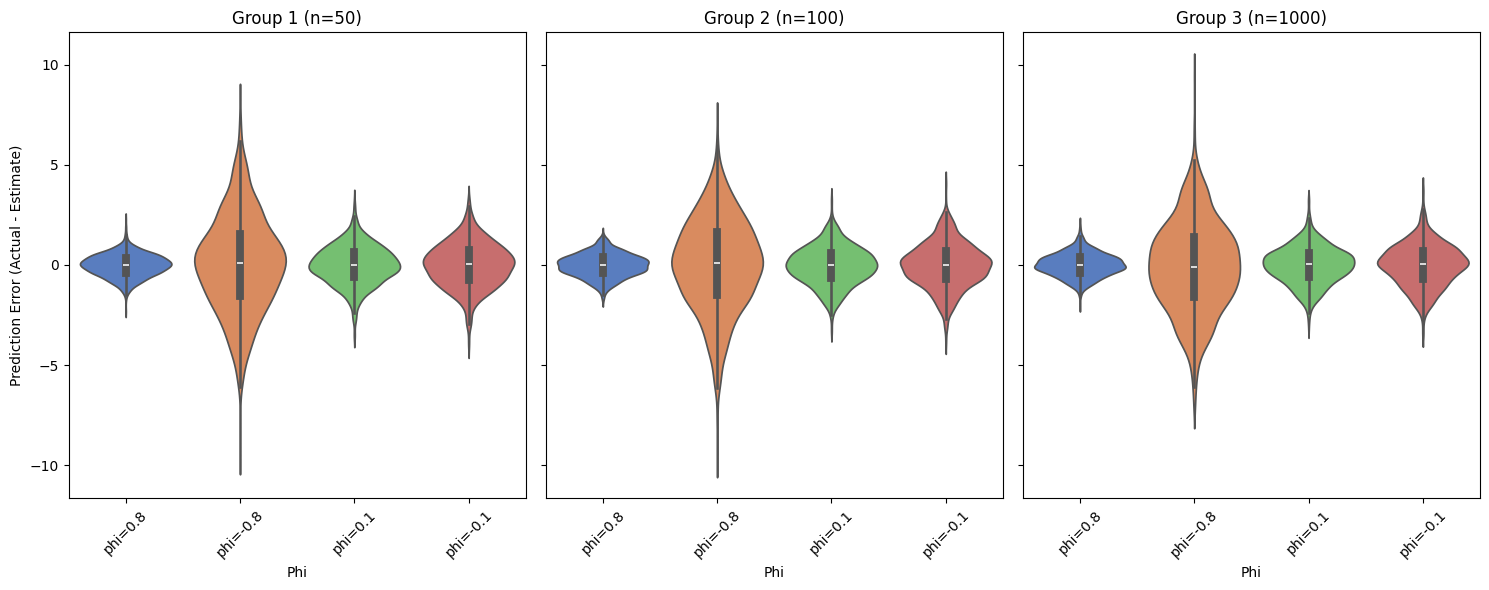

In [ ]:
phi_labels = ["phi=0.8", "phi=-0.8", "phi=0.1", "phi=-0.1"]

groups = {
    "Group 1 (n=50)": tables_ar3_to_ar1[:4],
    "Group 2 (n=100)": tables_ar3_to_ar1[4:8],
    "Group 3 (n=1000)": tables_ar3_to_ar1[8:]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, (group_name, group_tables) in zip(axes, groups.items()):
    group_data = pd.concat([
        table.assign(Phi=phi_label, Error=table["Actual_value"] - table["Next_Value_Estimate"])
        for table, phi_label in zip(group_tables, phi_labels)
    ], ignore_index=True)
    
    sns.violinplot(data=group_data, x="Phi", y="Error", palette="muted", ax=ax)
    ax.set_title(group_name)
    ax.set_xlabel("Phi")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

axes[0].set_ylabel("Prediction Error (Actual - Estimate)")

plt.tight_layout()
plt.show()
